# BatchedMELBO Performance

The goal of this notebook is to demonstrate the speed of training. We compare 3 training runs:
1. Using the original method..
2. Using BatchedMELBO without bf16.
3. Using BatchedMELBO with bf16.

We will train 256 vectors for 3 steps on 2 prompts on Qwen2.5-0.5B model using an RTX 5090 GPU.

In [25]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
TOKENIZER_NAME = "Qwen/Qwen2.5-0.5B-Instruct" 

SOURCE_LAYER = 8
TARGET_LAYER = 16
NORMALIZATION = 4.0
TOKEN_IDXS = slice(-3,None)
POWER = 2
POWERQ = 1
NUM_STEPS = 3
NUM_VECTORS = 256

EXAMPLES = [\
'''<|system|>
You are a helpful assistant

<|user|>
a=5+6, b=7+2. What is a*b?

<|assistant|>
''', '''<|system|>
You are a helpful assistant

<|user|>
What is the capital of France?

<|assistant|>
''']

# Original

In [26]:
%%time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto")

/workspace/batched_melbo/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


CPU times: user 6.48 s, sys: 1.37 s, total: 7.86 s
Wall time: 1.54 s


In [27]:
tokenizer.padding_side = "left"
tokenizer.pad_token_id

151643

In [28]:
import sys
from batched_melbo import original_melbo

original_method = original_melbo.SteeredModel(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    orthogonal_vectors = False,
    num_steps = NUM_STEPS,
    power = POWER,
    q = POWERQ,
    layers_name = "model.layers"
)


In [29]:
%%time
import time

start_time = time.time()
original_method.train(EXAMPLES, NUM_VECTORS)
end_time = time.time()

original_duration = end_time - start_time

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:58<00:00,  4.38it/s]

CPU times: user 58.4 s, sys: 131 ms, total: 58.5 s
Wall time: 58.5 s


# BatchedMELBO

In [30]:
%%time
from batched_melbo import batched_melbo

batched_melbo = batched_melbo.BatchedMELBO(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    num_steps = NUM_STEPS,
    power = POWER,
    q = POWERQ,
    layers_name = "model.layers"
)

CPU times: user 966 μs, sys: 45 μs, total: 1.01 ms
Wall time: 1.02 ms


In [31]:
%%time

start_time = time.time()
batched_melbo.train(EXAMPLES, NUM_VECTORS, vector_batch_size=128)
end_time = time.time()

batched_melbo_duration = end_time - start_time

Training batch 1 of 3:   0%|          | 0/3 [00:00<?, ?it/s]

Training batch 2 of 3: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

CPU times: user 1.94 s, sys: 12 ms, total: 1.95 s
Wall time: 1.75 s


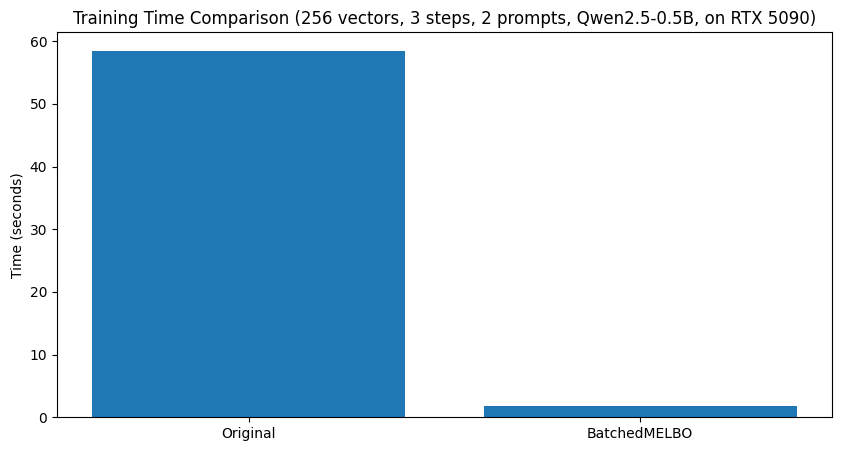

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(['Original', 'BatchedMELBO'], [original_duration, batched_melbo_duration])
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison (256 vectors, 3 steps, 2 prompts, Qwen2.5-0.5B, on RTX 5090)')
plt.show()

# Bonus: more juice by enabling mixed-precision training

Support for mixed-precision training has been added to BatchedMELBO, so vectors can be trained in bf16 by loading your model in half-precision. This gives an extra 2x to 3x boost to training speed.

In [33]:
del model, original_method, batched_melbo
import gc
gc.collect()
torch.cuda.empty_cache()

In [34]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.bfloat16)

In [35]:
from batched_melbo import batched_melbo

batched_melbo_bf16 = batched_melbo.BatchedMELBO(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    num_steps = NUM_STEPS,
    power = POWER,
    q = POWERQ,
    layers_name = "model.layers"
)

In [36]:
%%time

start_time = time.time()
batched_melbo_bf16.train(EXAMPLES, NUM_VECTORS, vector_batch_size=128)
end_time = time.time()

batched_melbo_bf16_duration = end_time - start_time

Training batch 1 of 3:   0%|          | 0/3 [00:00<?, ?it/s]

Training batch 2 of 3: 100%|██████████| 3/3 [00:00<00:00, 10.03it/s]

CPU times: user 798 ms, sys: 40.5 ms, total: 838 ms
Wall time: 643 ms


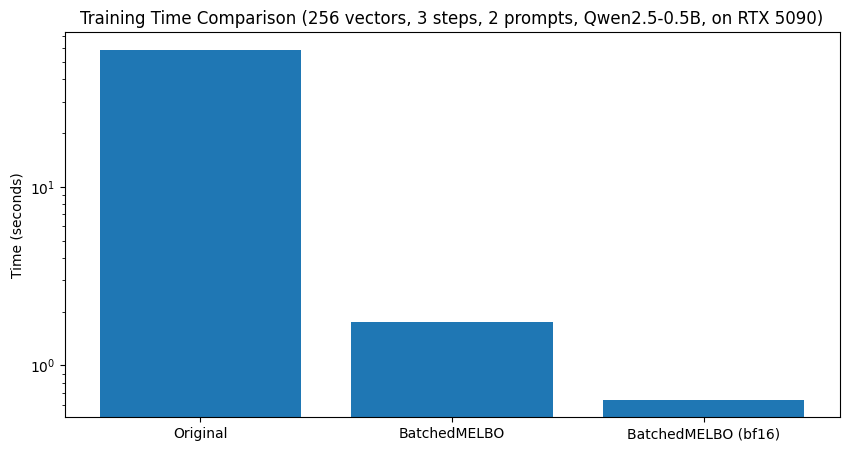

In [37]:
plt.figure(figsize=(10, 5))
plt.bar(['Original', 'BatchedMELBO', 'BatchedMELBO (bf16)'], [original_duration, batched_melbo_duration, batched_melbo_bf16_duration])
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison (256 vectors, 3 steps, 2 prompts, Qwen2.5-0.5B, on RTX 5090)')
plt.yscale('log')
plt.show()